In [1]:
import os
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ,SSR,MIOSR
from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import dill
import jax.numpy as jnp
import time
import matplotlib.pyplot as plt
from pysindy import EnsembleOptimizer
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'serif'
import matplotlib as mpl
# mpl.rcParams.update({"text.usetex":True})
save_path = 'data.pkl'


/home/grisal/github/jsindy/.venv/lib/python3.12/site-packages/sympy2jax/sympy_module.py:291: UserWarning: `equinox.static_field` is deprecated in favour of `equinox.field(static=True)`
  has_extra_funcs: bool = eqx.static_field()


# Run and Save Data/Model

In [3]:
initial_state = jnp.array([ -8,8,27.])
dt = 0.5
noise_var = 0.0
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 505
expdata = LorenzExp(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=29,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)

In [4]:
trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 10000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100,
)
data_weight =  1.
colloc_weight = 1e5
sparsifier = pySindySparsifier(
    STLSQ(threshold = 0.5,alpha = 0.01)
    )

optimizer = AlternatingActiveSetLMSolver(
        beta_reg=1e-3,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=expdata.feature_names
)

model.fit(
    expdata.t_train,
    expdata.x_train,
    t_colloc = expdata.t_colloc,
    w_colloc = expdata.w_colloc
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
metrics['model_params'] = model.params


{'show_progress': True, 'sigma2_est': Array(43.84970067, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 100000.0}
Warm Start


  0%|          | 0/10000 [00:00<?, ?it/s]

Iteration 0, loss = 7.387e+08, gradnorm = 6.238e+08, alpha = 11.25, improvement_ratio = 0.4318
Iteration 1, loss = 3.533e+08, gradnorm = 6.195e+09, alpha = 25.31, improvement_ratio = 0.5218
Iteration 2, loss = 1.876e+08, gradnorm = 3.006e+09, alpha = 37.97, improvement_ratio = 0.4689
Iteration 3, loss = 4.067e+07, gradnorm = 5.741e+09, alpha = 37.97, improvement_ratio = 0.7832
Iteration 4, loss = 1.023e+07, gradnorm = 1.585e+09, alpha = 37.97, improvement_ratio = 0.7484
Iteration 5, loss = 7.47e+06, gradnorm = 7.1e+08, alpha = 56.95, improvement_ratio = 0.2702
Iteration 100, loss = 726.7, gradnorm = 2.702e+05, alpha = 506.2, improvement_ratio = 0.7146
Iteration 200, loss = 489.8, gradnorm = 1.161e+06, alpha = 337.5, improvement_ratio = 0.289
Iteration 300, loss = 306.5, gradnorm = 3.621e+05, alpha = 225.0, improvement_ratio = 0.5172
Iteration 400, loss = 247.7, gradnorm = 2.853e+05, alpha = 150.0, improvement_ratio = 0.5218
Iteration 500, loss = 221.4, gradnorm = 3.236e+05, alpha = 100

In [5]:
t_grid = jnp.linspace(t0,10,1000)
state_preds = model.predict_state(t_grid)
true_states = jax.vmap(expdata.system_sol.evaluate)(t_grid)


## simulate on unseen data

In [6]:
import diffrax
from data.lorenz import lorenz_system


true_system = jax.jit(lorenz_system)

jit_lor_pred = jax.jit(model.predict)


def learned_system(t,x,args):
    return jit_lor_pred(x)



def simulate_sol(y0,system, t0=expdata.t0,t1=expdata.t1,dt=expdata.dt,t_eval = expdata.t_true, args = None):
    term = diffrax.ODETerm(system)
    solver = diffrax.Tsit5()

    save_at = diffrax.SaveAt(dense=True)
    sol = diffrax.diffeqsolve(
        term,
        solver,
        t0 = t0,
        t1=t1,
        dt0=dt,
        y0=y0,
        args = args,
        saveat=save_at,
        max_steps=int(10*(t1-t0)/dt)
    )

    return jax.vmap(sol.evaluate)(t_eval)


In [7]:
lorenz_args = (expdata.sigma,expdata.rho, expdata.beta)
x_train = expdata.x_train
t_new = jnp.linspace(0,15, 1010)
t_extend = t_new + t_grid[-1]

x_true_extend = simulate_sol(x_train[-1],system=true_system,t0=t_new[0],t1=t_new[-1], t_eval=t_new, args=lorenz_args)
x_sim_extend = simulate_sol(x_train[-1],system=learned_system,t0=t_new[0],t1=t_new[-1], t_eval=t_new,)

In [8]:
t_extend = jnp.linspace(10,25,501)

x_true_extend = simulate_sol(x_train[-1],system=true_system,t0=t_extend[0],t1=t_extend[-1], t_eval=t_extend, args=lorenz_args)
x_sim_extend = simulate_sol(x_train[-1],system=learned_system,t0=t_extend[0],t1=t_extend[-1], t_eval=t_extend,)


## Save data

In [9]:
data = {
    "t_true": t_grid,
    "x_true": true_states,
    "x_pred": state_preds,
    "t_train": expdata.t_train,
    "x_train": expdata.x_train,
    "t_extend": t_extend,
    "x_true_extend": x_true_extend,
    "x_sim_extend":x_sim_extend,
    "true_theta":expdata.true_coeff.T,
    "model": model
}

# _ = data.pop("model")

with open(save_path,'wb') as file:
    dill.dump(data,file)

In [10]:
os.path.getsize(save_path) / 1e6

221.118277

# Load Data/Model

In [2]:
with open(save_path, 'rb') as file:
    data = dill.load(file)

t_true = data["t_true"]
x_true = data["x_true"]
x_pred = data["x_pred"]

t_train = data["t_train"]
x_train = data["x_train"]

t_extend = data["t_extend"]
x_true_extend = data["x_true_extend"]
x_sim_extend = data["x_sim_extend"]
true_theta = data['true_theta']

model = data["model"]

In [3]:
noise = 0
noise/jnp.std(x_true,axis=0)

Array([0., 0., 0.], dtype=float64)

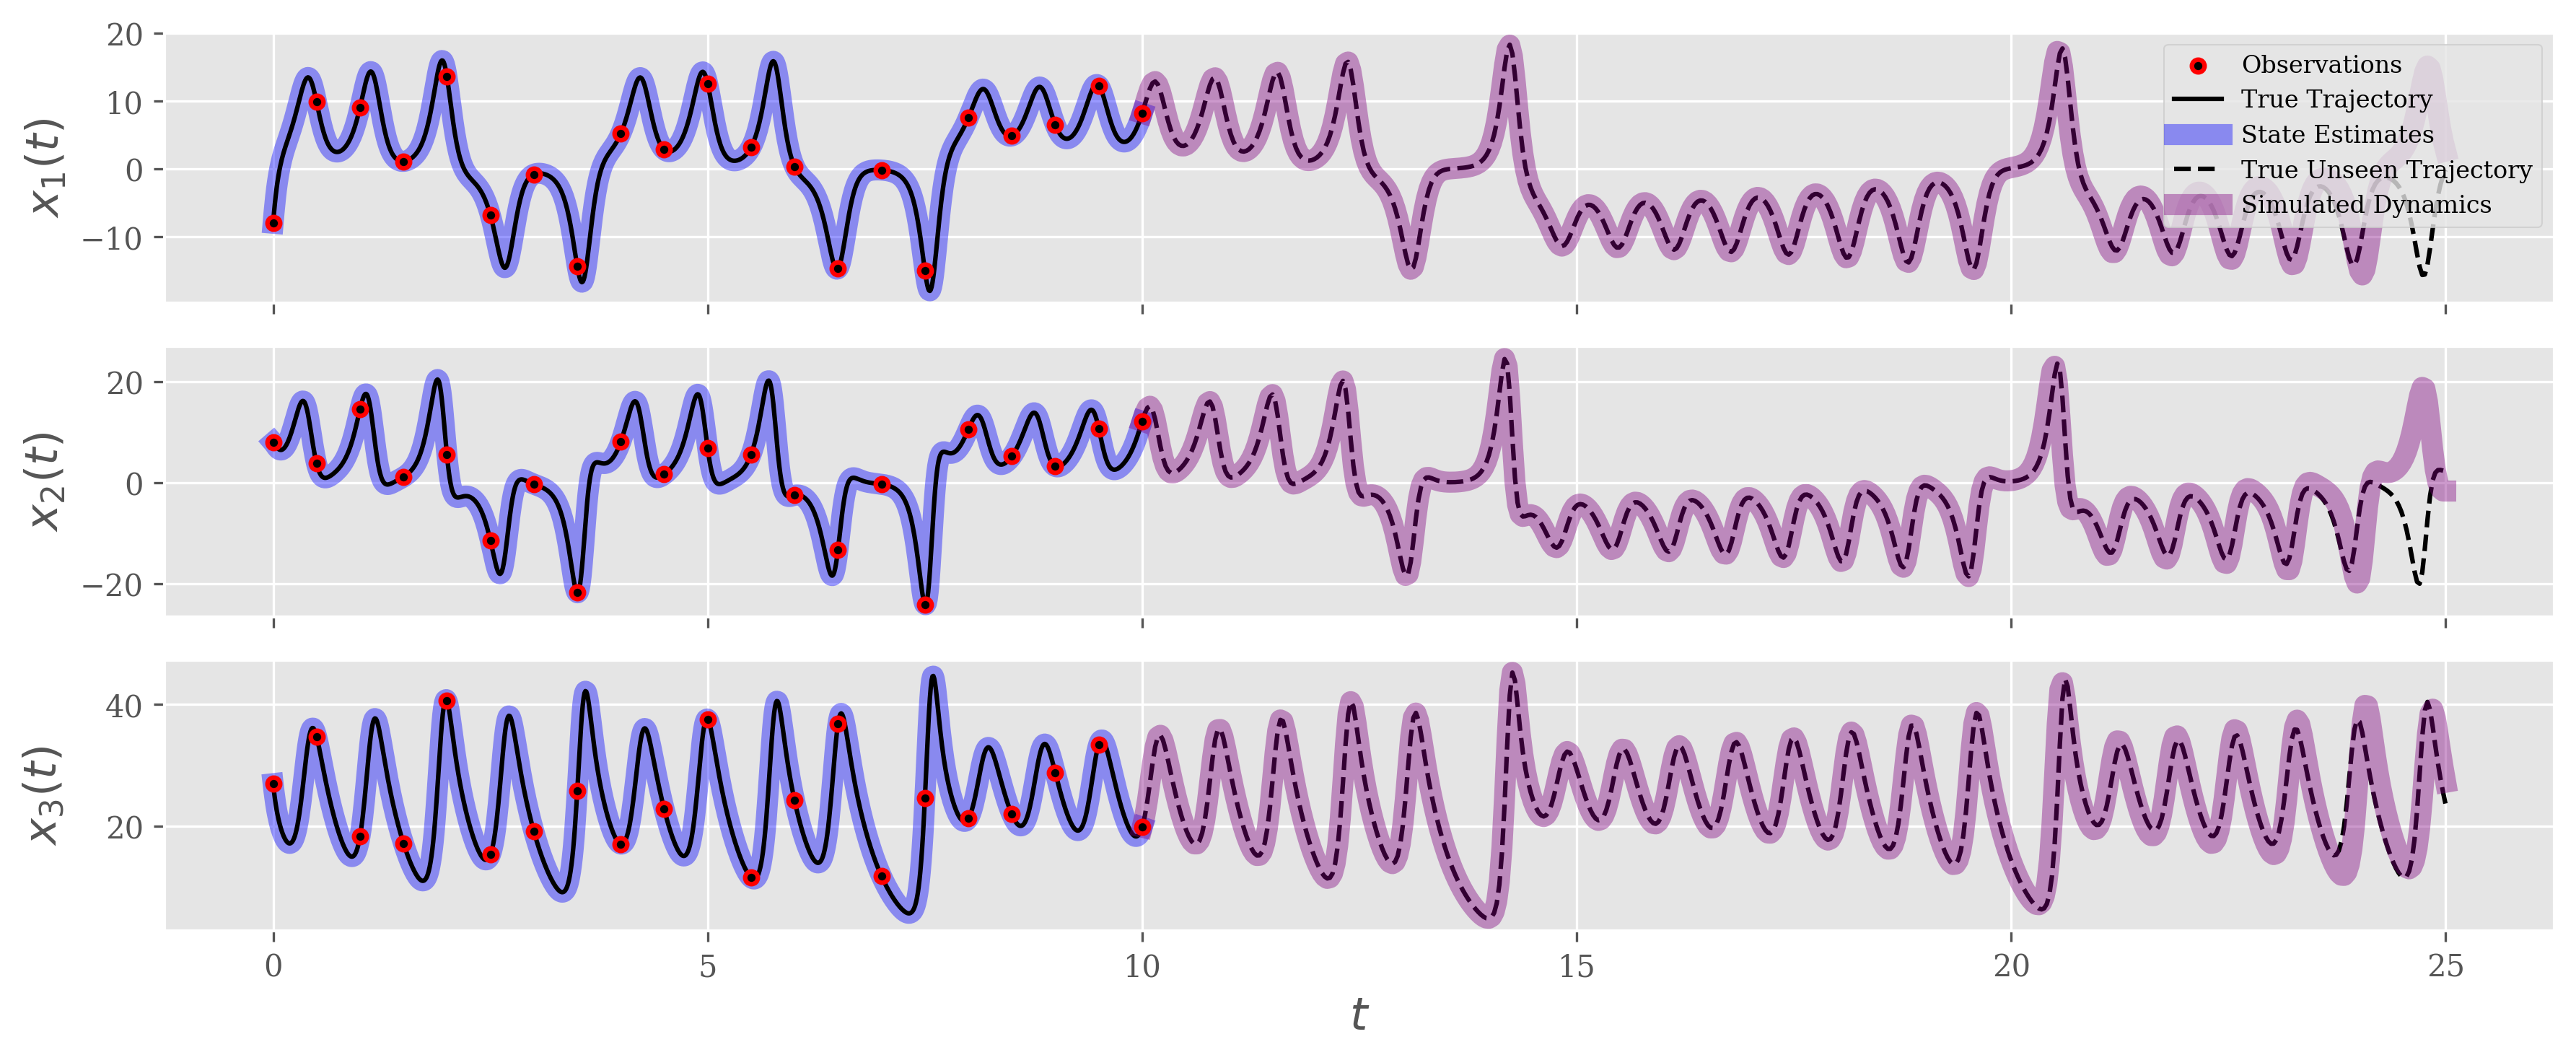

In [4]:
fig, axs  = plt.subplots(3,1, figsize=(12,5),sharex=True,dpi=300)

axs = axs.flatten()
lw=1.5

y_labels = [r"$x_1(t)$", r"$x_2(t)$", r"$x_3(t)$"]
for idx, ax in enumerate(axs):
    ax.scatter(t_train,x_train[:,idx],zorder = 3, facecolors='black', edgecolors='red', label="Observations", s=18,lw=1.5)
    ax.plot(t_true,x_true[:,idx],label = 'True Trajectory',c='black',zorder=2)
    ax.plot(t_true,x_pred[:,idx],label='State Estimates', linestyle='-',c='blue', alpha=0.4,lw=7,zorder=1)

    # extended
    
    ax.plot(t_extend, x_true_extend[:,idx],c='black', linestyle='--', label='True Unseen Trajectory')
    ax.plot(t_extend, x_sim_extend[:,idx],c='purple',alpha=0.4, lw=7,linestyle='-',label='Simulated Dynamics')

    if idx> 1:
        ax.set_ylabel(y_labels[idx],size=15, rotation = 90,labelpad=13)
    else:
        ax.set_ylabel(y_labels[idx],size=15, rotation = 90)

    if idx == 0:
        ax.legend(loc ='upper right',prop={'size':8})
    if idx == len(y_labels) - 1:
        ax.set_xlabel(r"$t$", size=15)

plt.tight_layout()
# plt.savefig("scarce_lorenz.pdf")
plt.show()

# Metrics

- rmse of stuff
- mean aboslute error of coeff


In [5]:
mse = jnp.mean(jnp.mean((x_true - x_pred)**2,axis=0)/jnp.var(x_true,axis=0))
rmse = jnp.sqrt(mse)
mae = jnp.linalg.norm(true_theta - model.theta) / jnp.linalg.norm(true_theta)
# mse_sim = jnp.mean((x_true_extend - x_sim_extend)**2,axis=0)/jnp.var(x_true_extend,axis=0)


In [12]:
print(f"{jnp.mean(mse).item():.3e}")
print(f"{mae:.3e}")

2.586e-06
1.956e-03


In [6]:
mse.item(), rmse.item(), mae.item()

(2.5860010033568777e-06, 0.001608104786186795, 0.00235592935866594)

In [24]:
# diff = x_true_extend - x_sim_extend
# diff2 = diff ** 2
# x2 = x_true_extend ** 2

# # cumulative sums along time
# cum_sum_diff2 = jnp.cumsum(diff2, axis=0)
# cum_sum_x = jnp.cumsum(x_true_extend, axis=0)
# cum_sum_x2 = jnp.cumsum(x2, axis=0)

# # time indices (avoid divide by zero)
# counts = jnp.arange(1, len(x_true_extend) + 1).reshape(-1, 1)

# # compute running means
# mean_x = cum_sum_x / counts
# mean_diff2 = cum_sum_diff2 / counts

# # compute running variances using E[X^2] - (E[X])^2
# var_x = (cum_sum_x2 / counts) - mean_x**2

# # compute normalized MSE (elementwise variance normalization)
# mse_sim_cum = mean_diff2 / var_x


In [25]:
# for thing in mse_sim_cum.T:
#     plt.plot(t_extend,thing)
#     plt.show()

# Long time simulation

In [12]:
lorenz_args = (expdata.sigma,expdata.rho, expdata.beta)

t_new = expdata.t_true
t_new = jnp.linspace(0,100, 1010)

x_true_extend = simulate_sol(x_train[-1],system=true_system,t0=t_new[0],t1=t_new[-1], t_eval=t_new, args=lorenz_args)
x_sim_extend = simulate_sol(x_train[-1],system=learned_system,t0=t_new[0],t1=t_new[-1], t_eval=t_new,)

In [14]:
t_new += t_true[-1]

In [15]:
idx_25 = 1010//4
j = 0

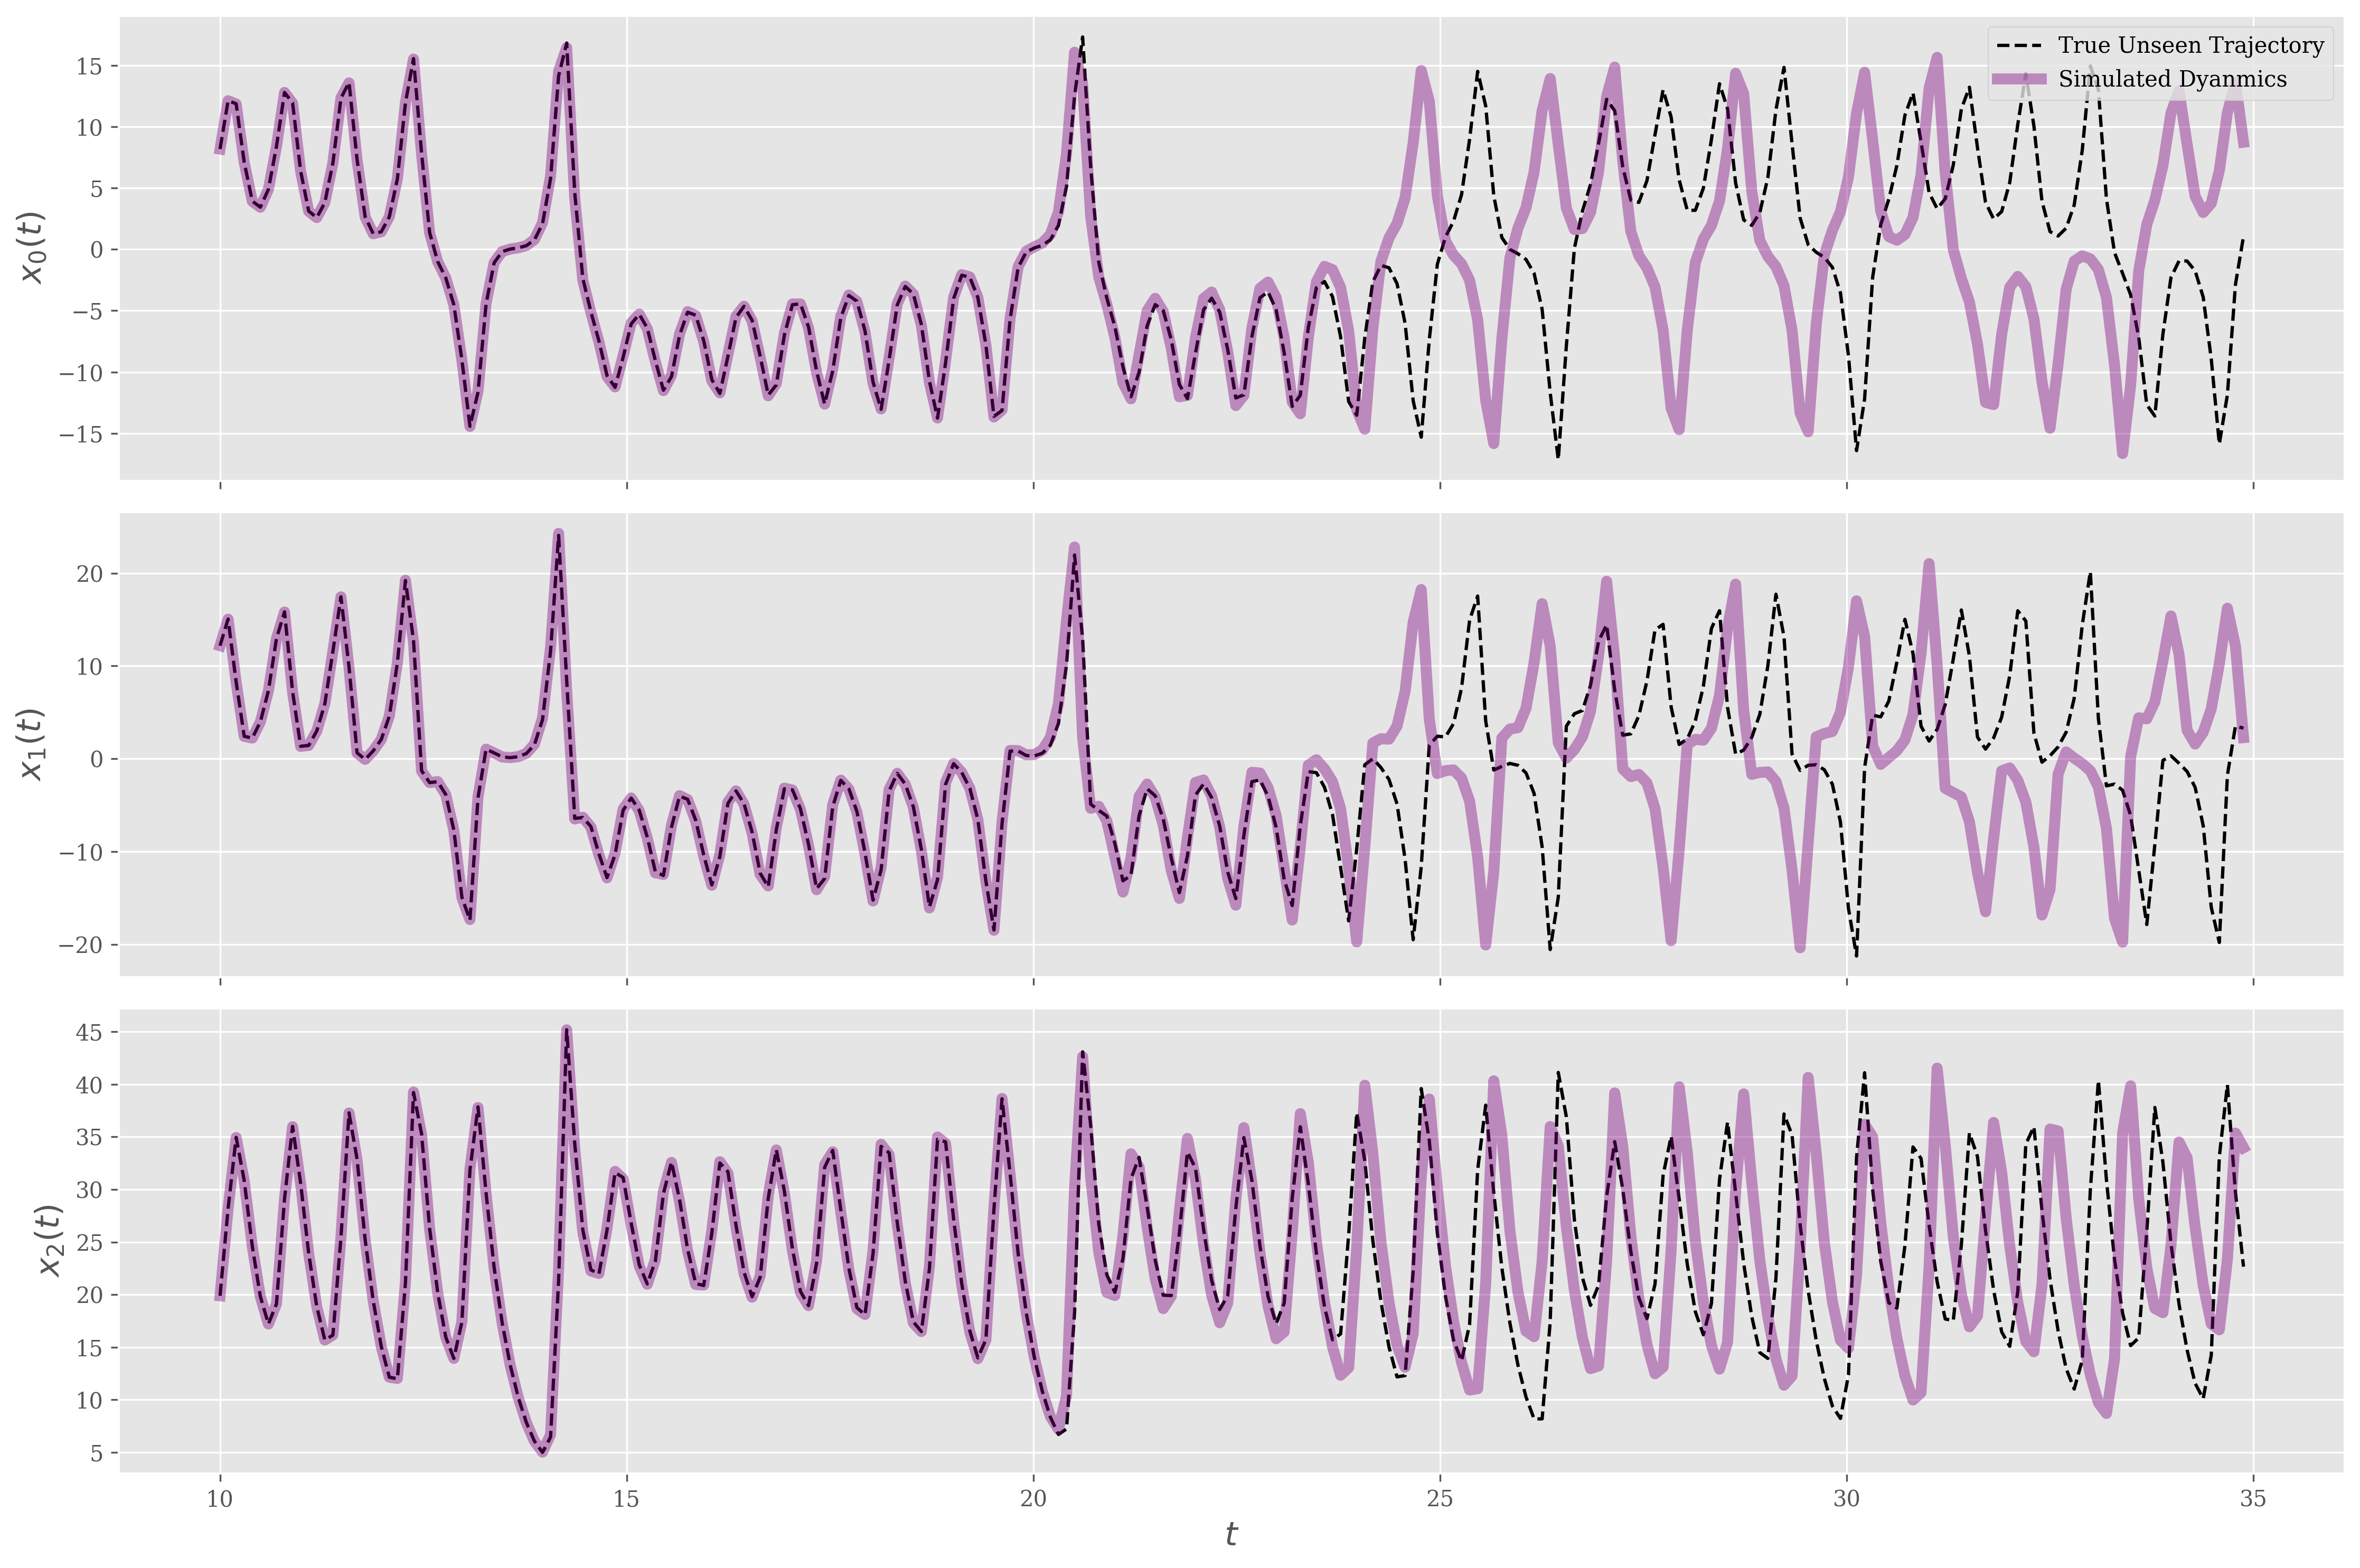

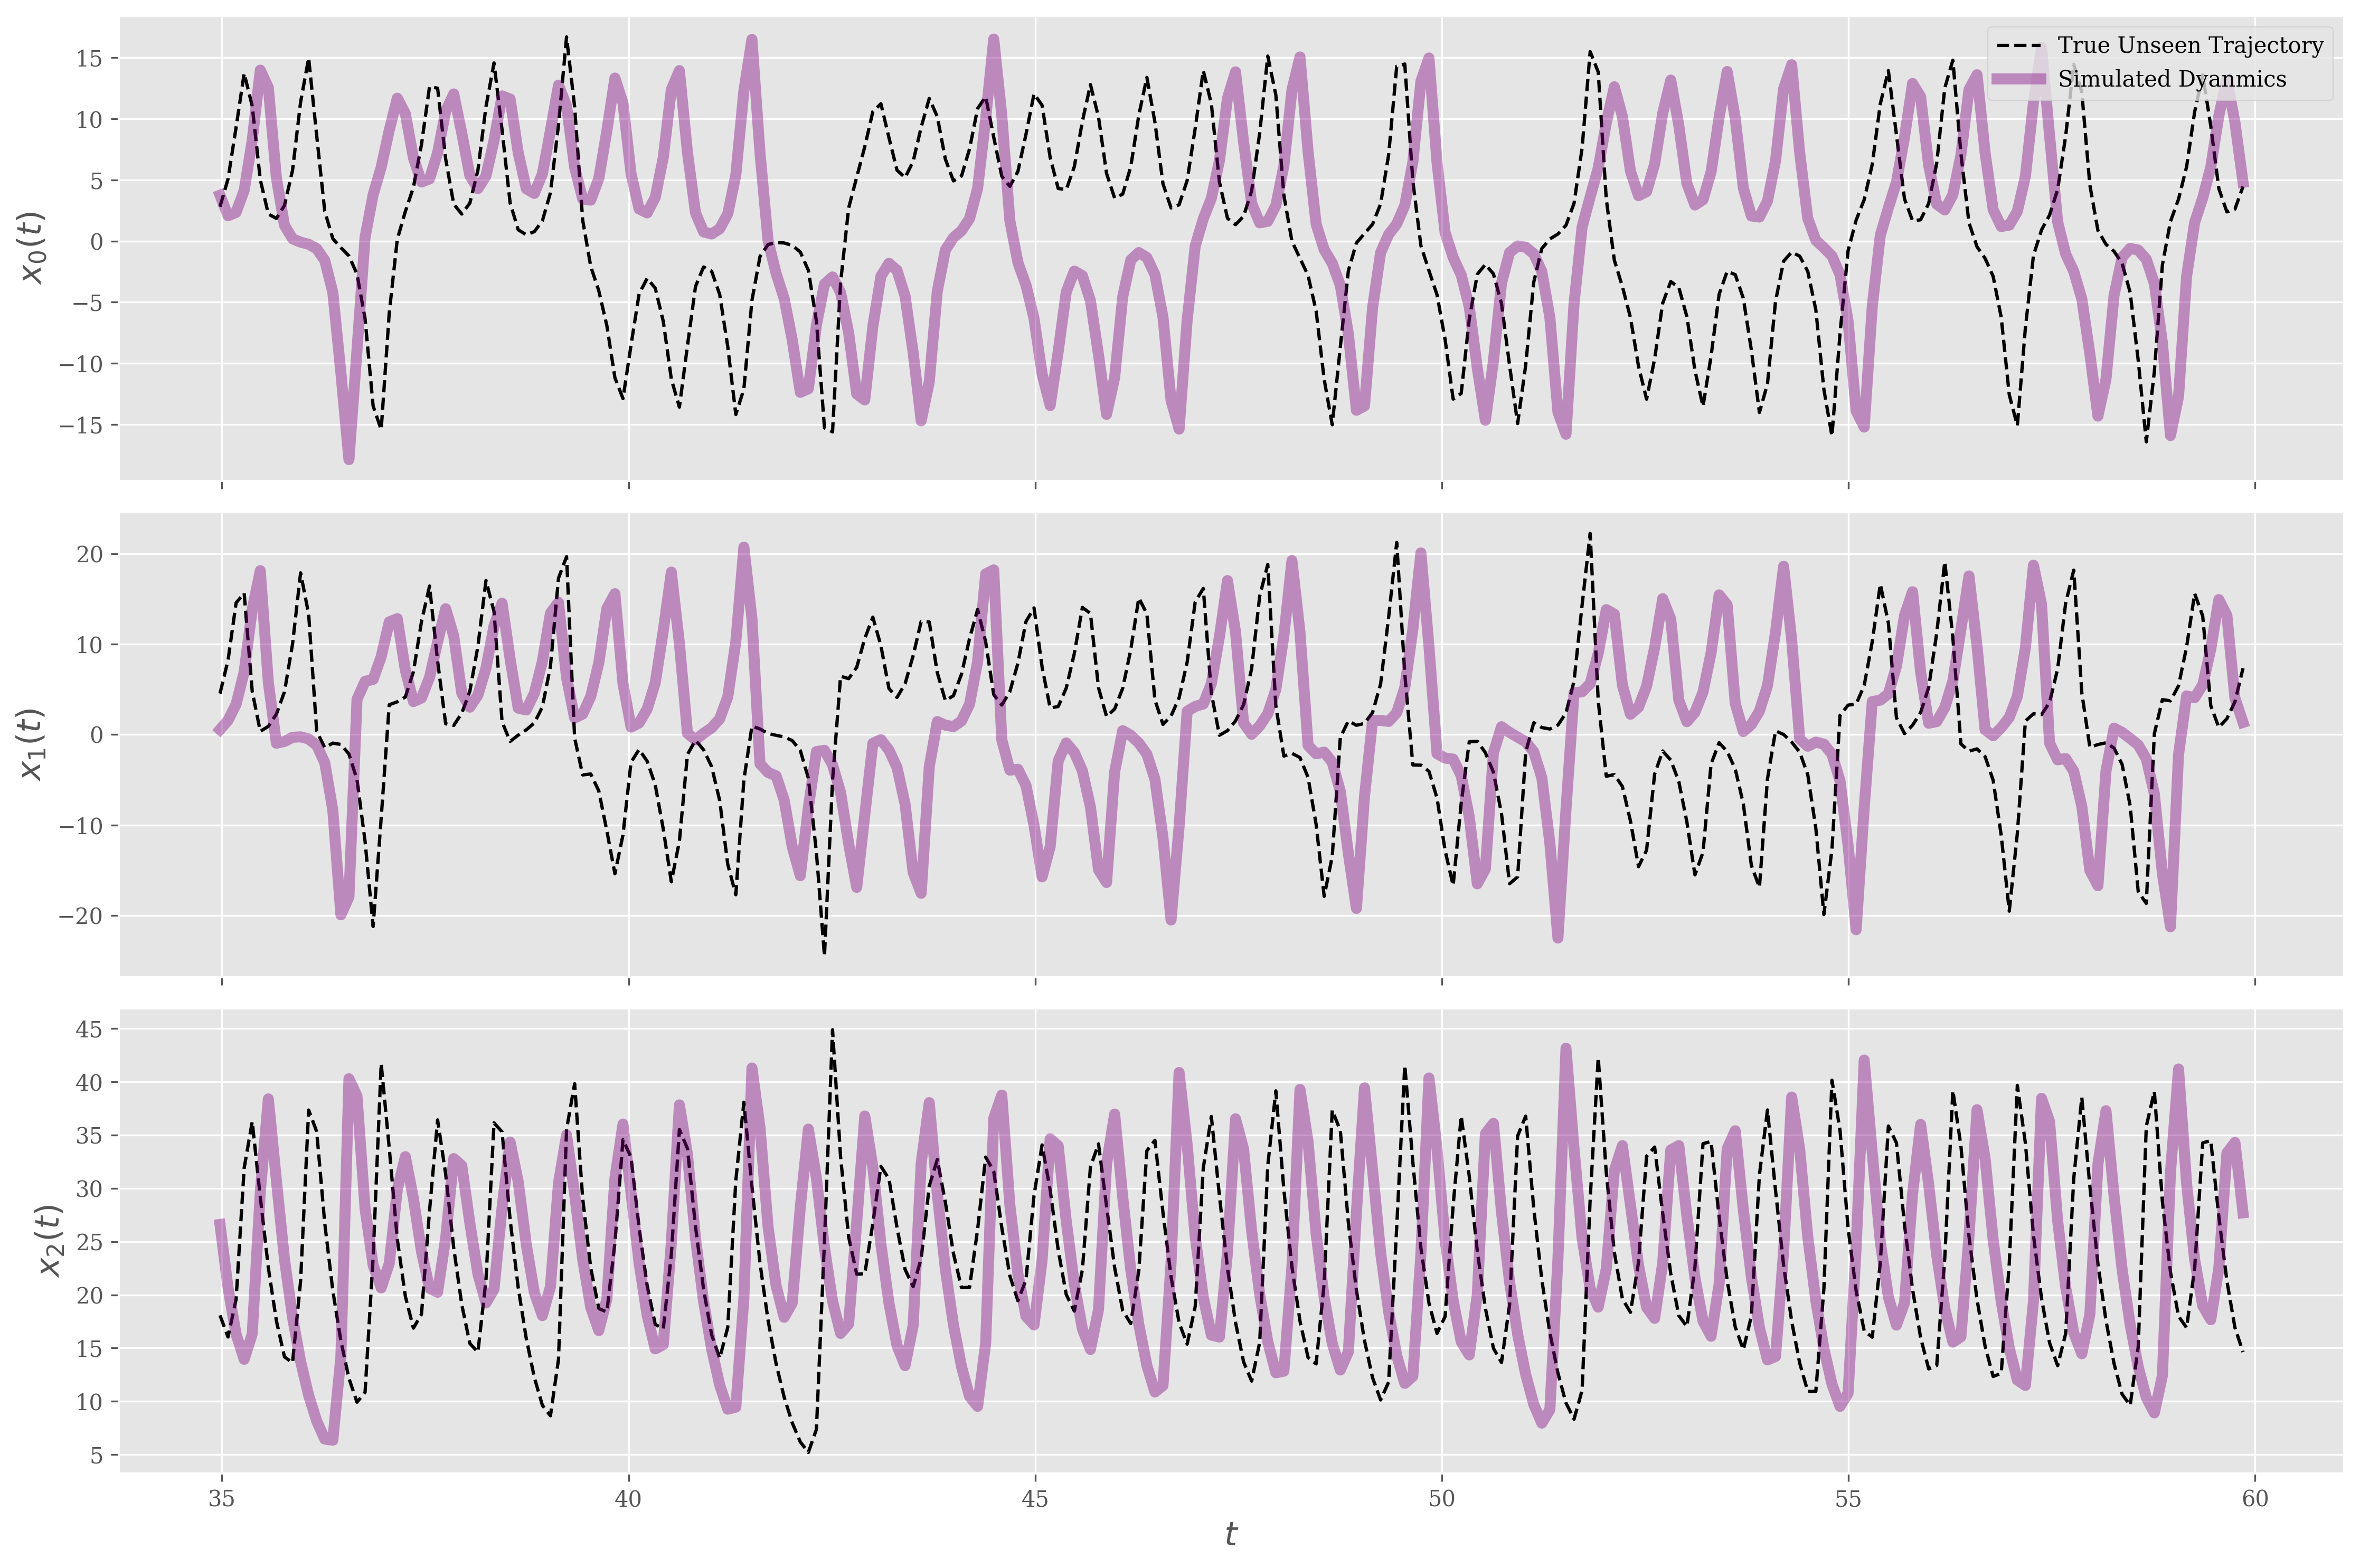

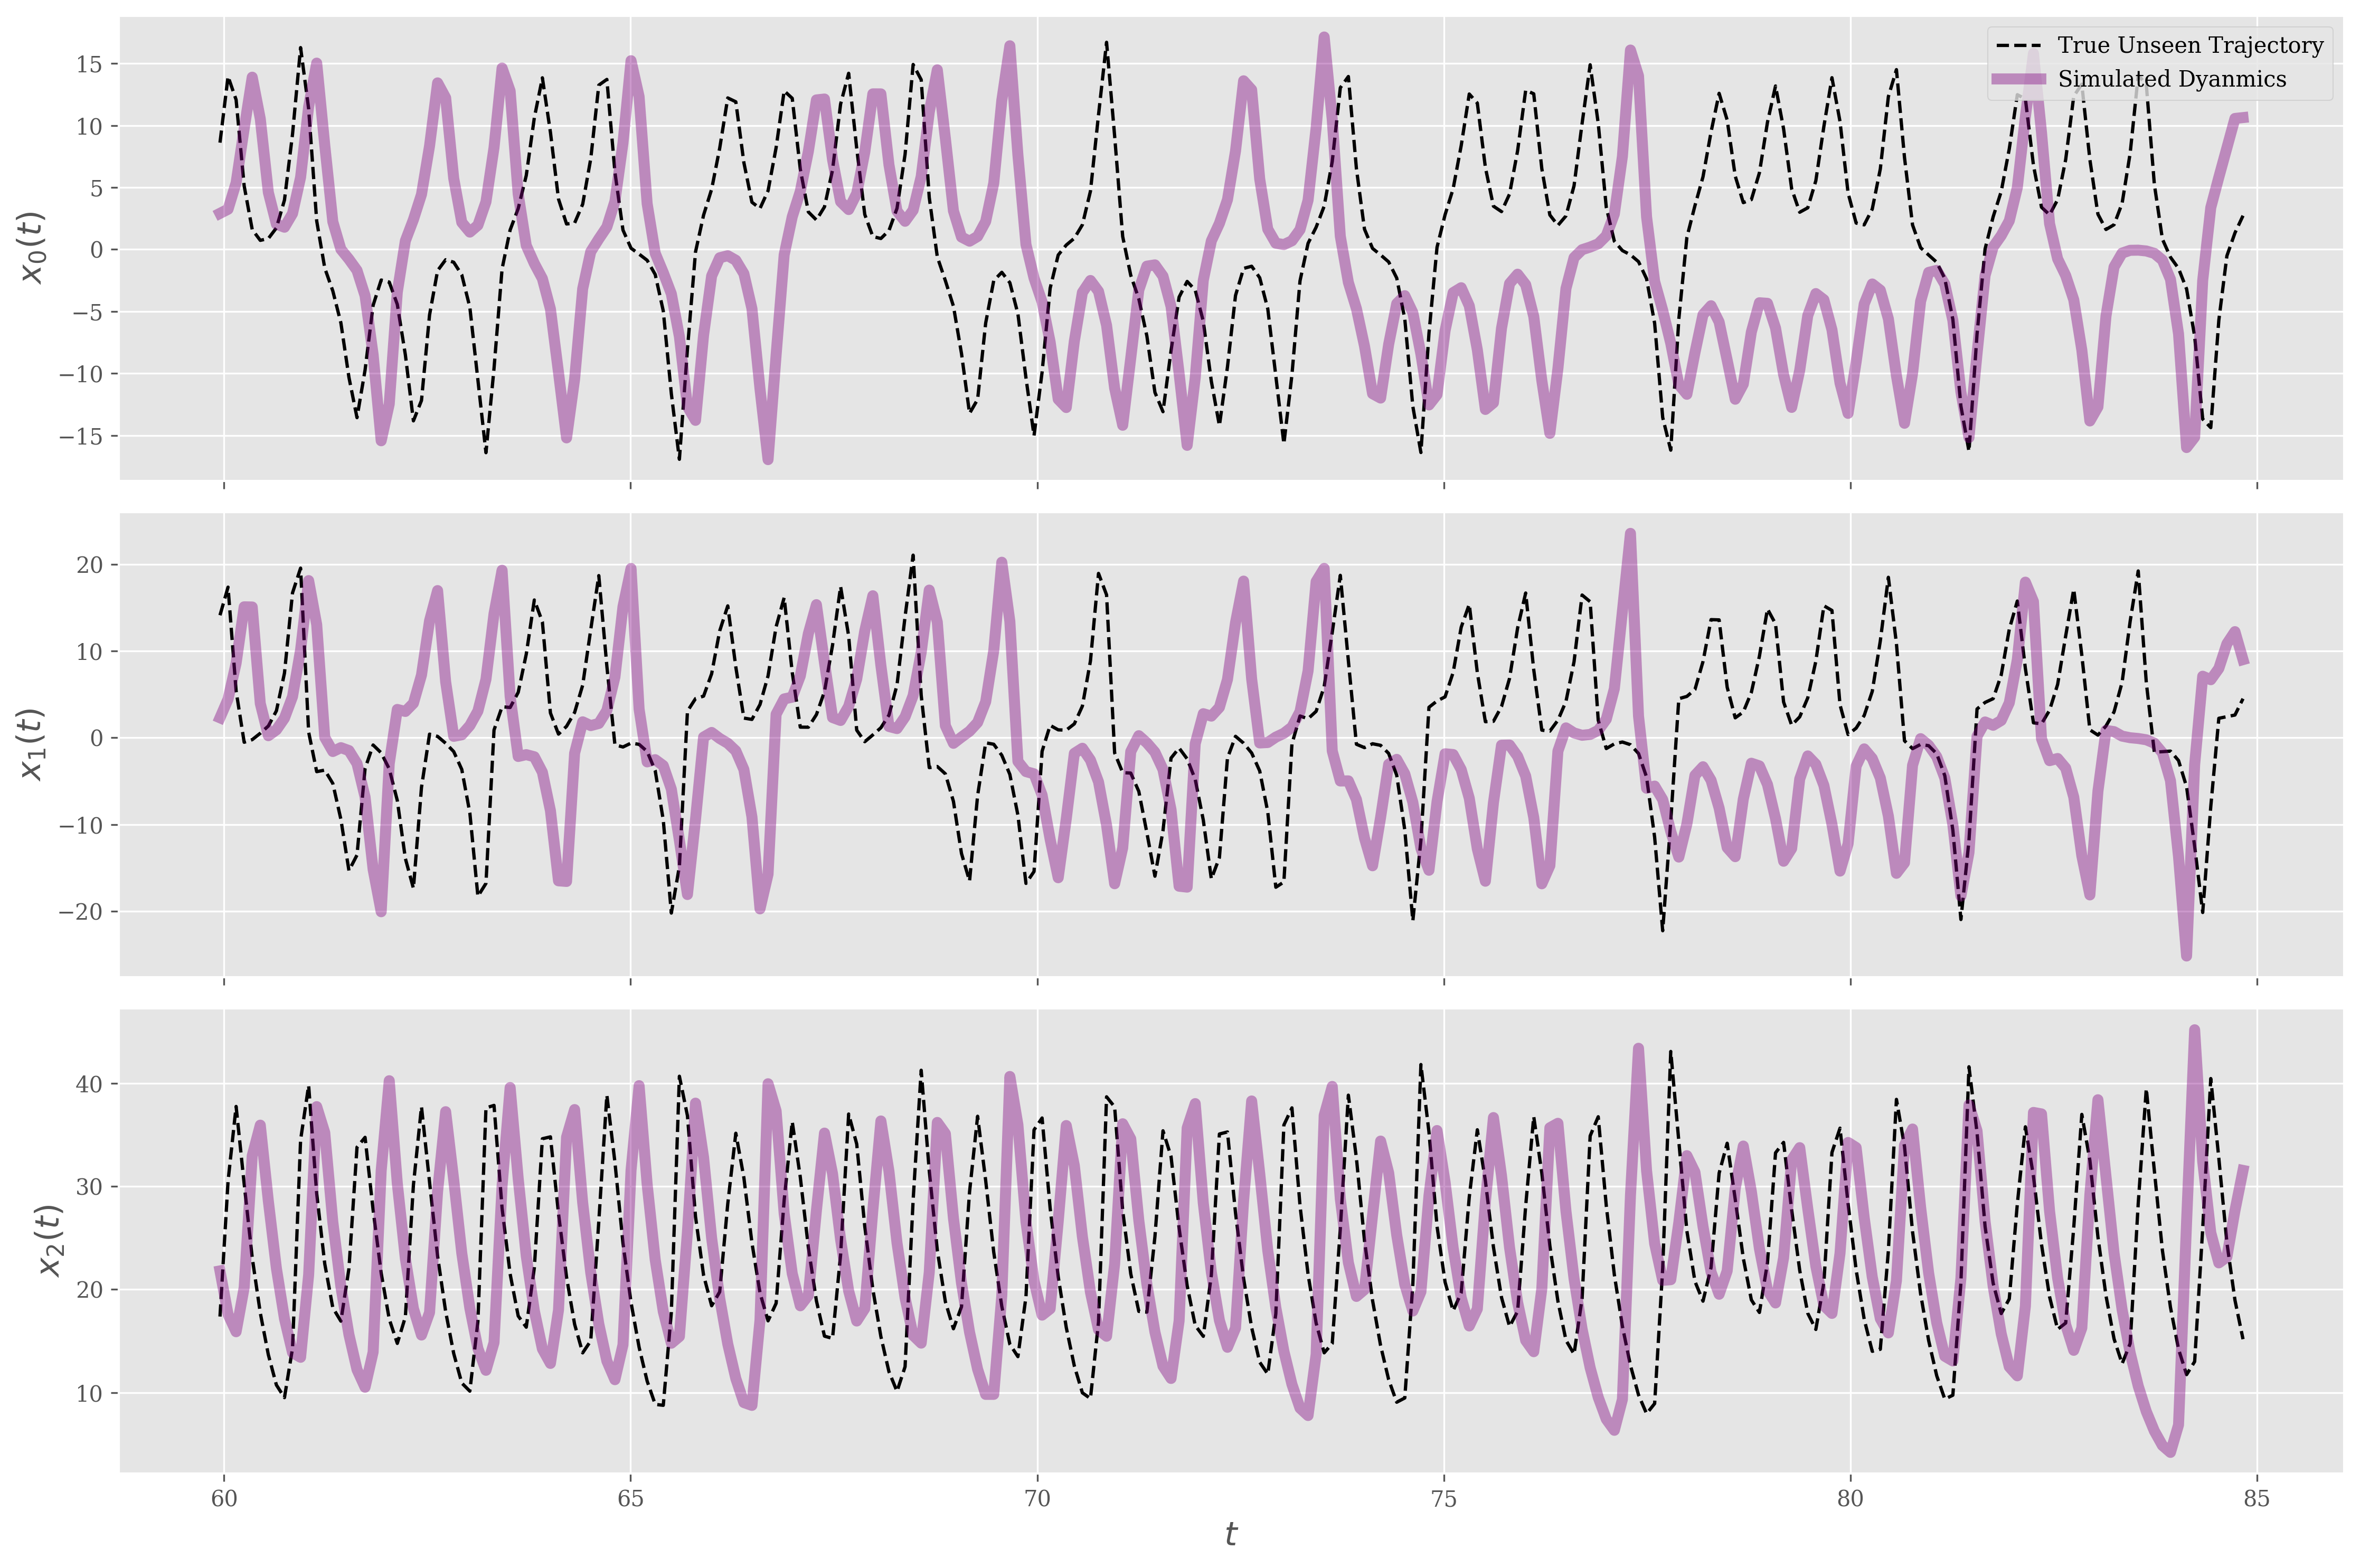

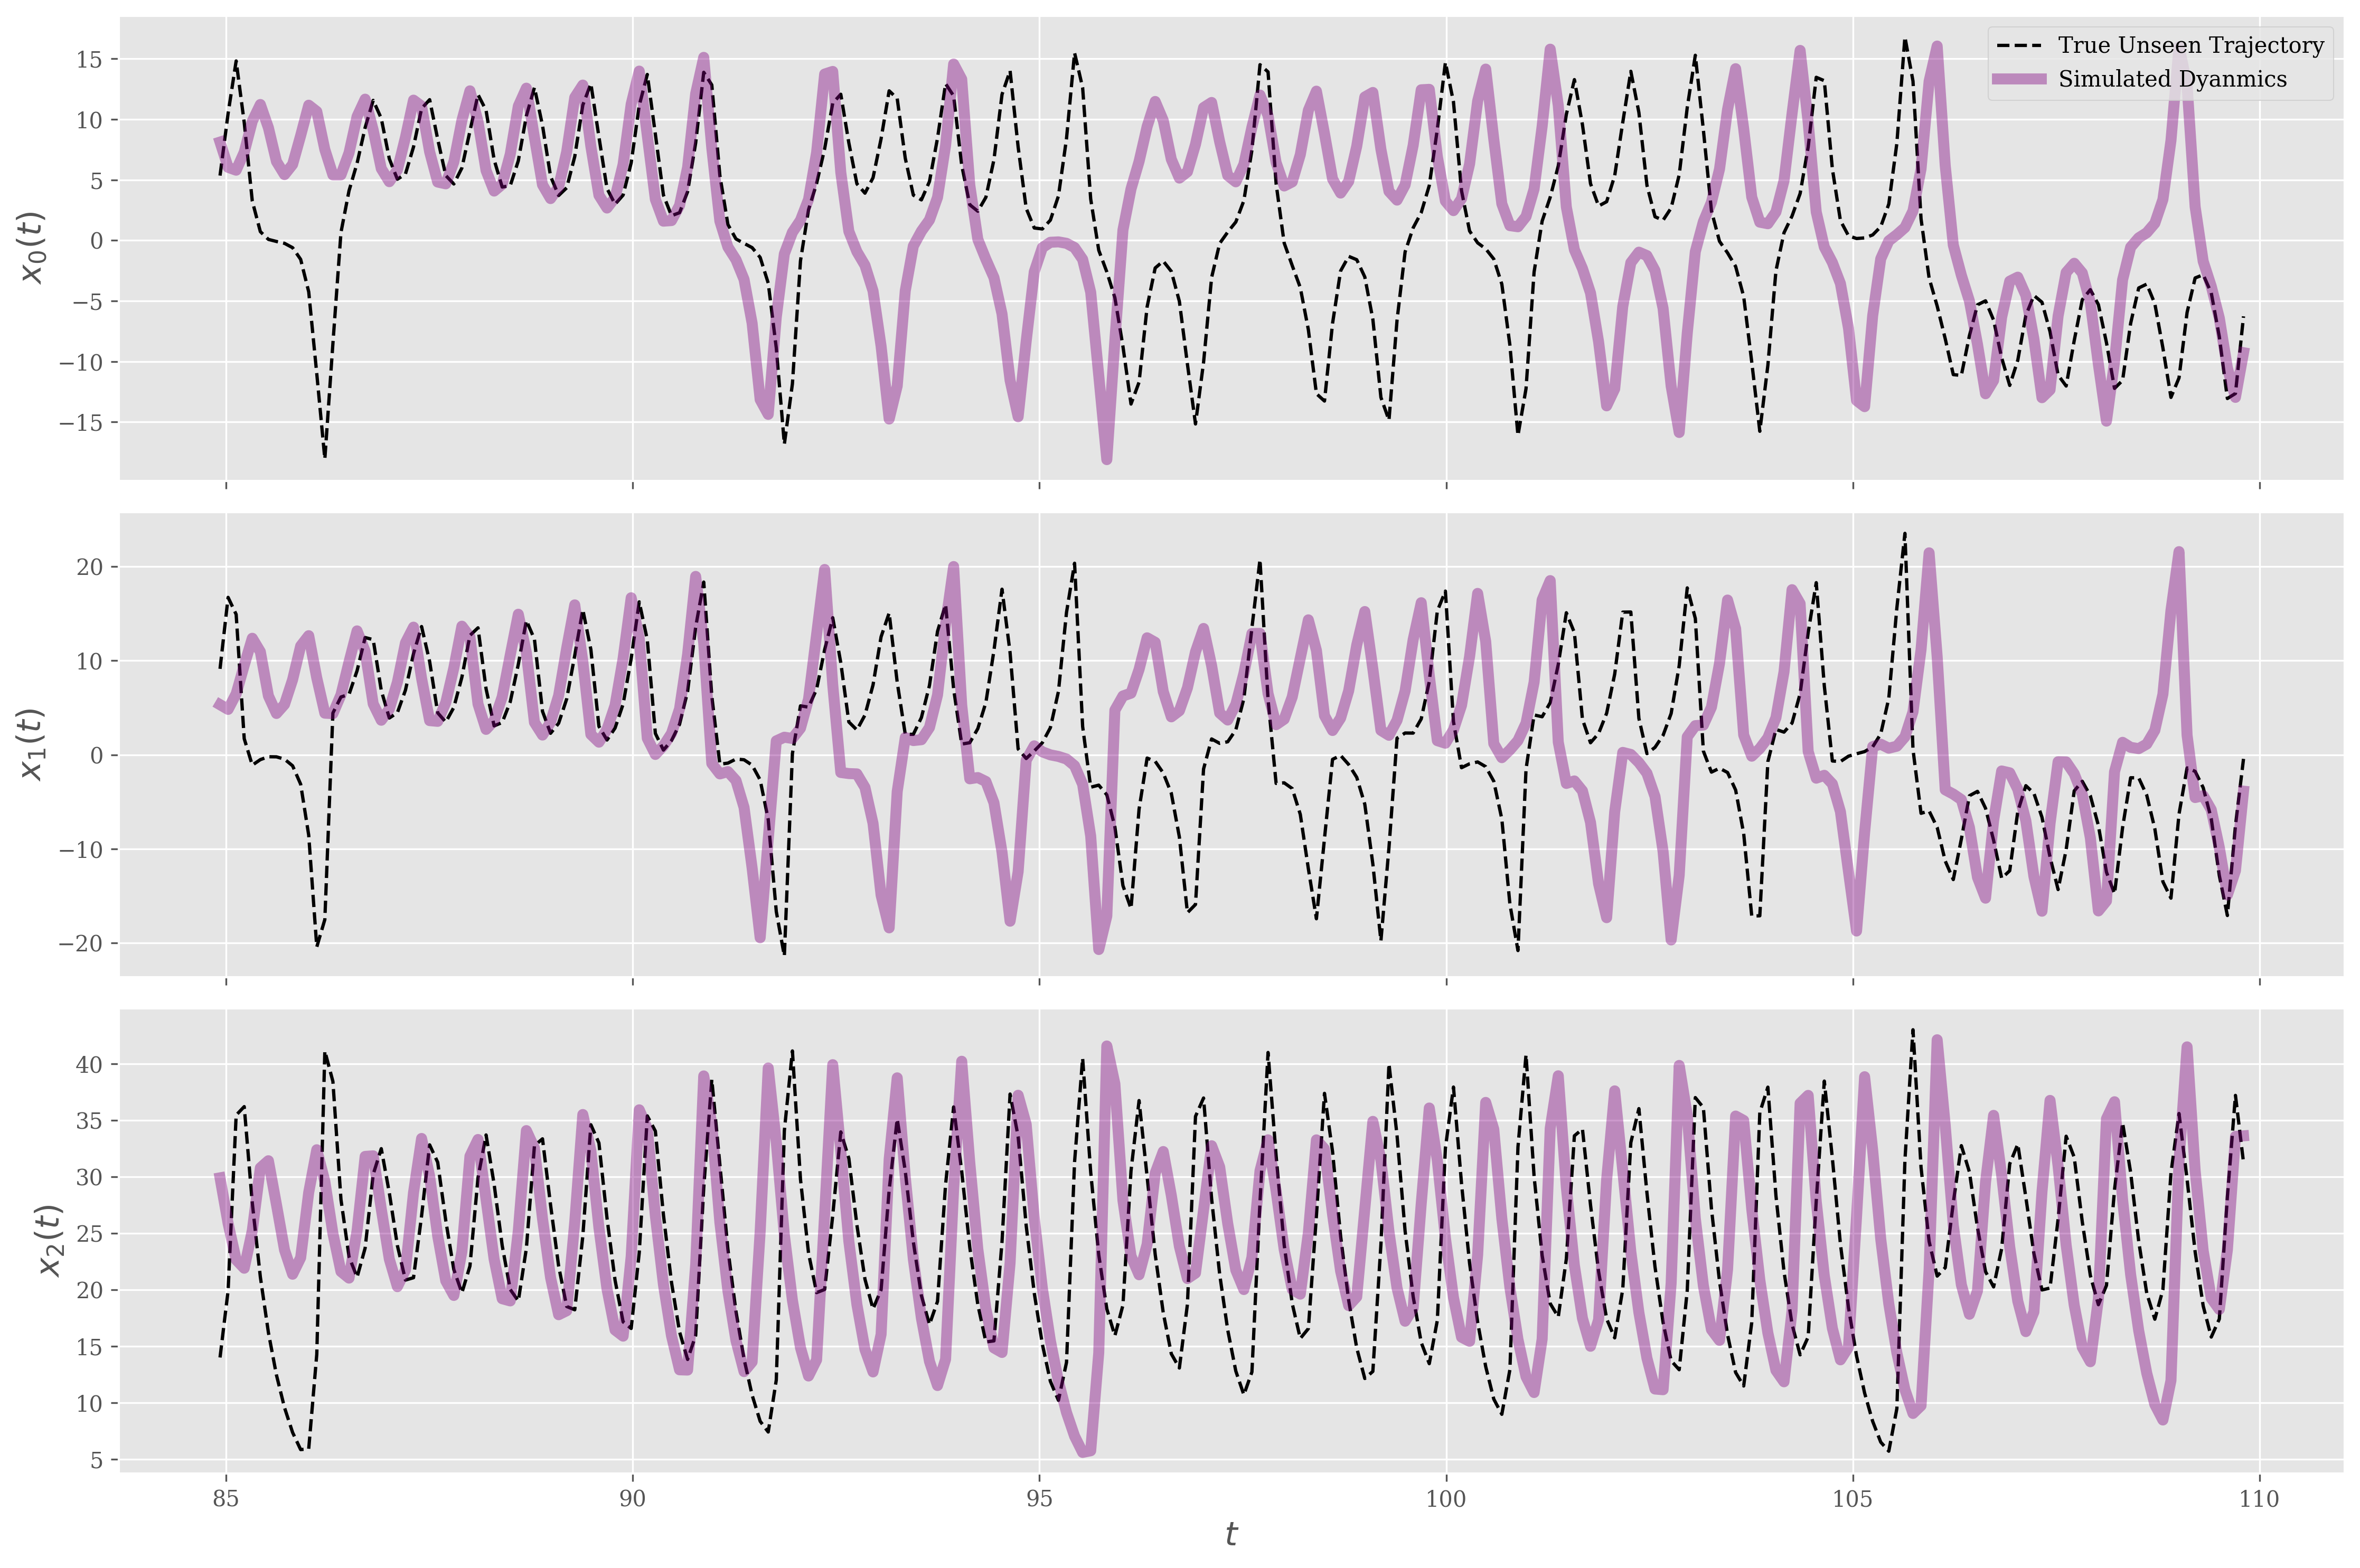

In [16]:
for j in range(4):
    fig, axs  = plt.subplots(3,1, figsize=(15,10),sharex=True,dpi=300)

    axs = axs.flatten()

    y_labels = [r"$x_0(t)$", r"$x_1(t)$", r"$x_2(t)$"]
    for idx, ax in enumerate(axs):
        # ax.scatter(expdata.t_train,expdata.x_train[:,idx],zorder = 3, facecolors='black', edgecolors='red', label="Observations", s=70,lw=1.5)
        # ax.plot(t_grid,true_states[:,idx],label = 'True Trajectory',c='black',zorder=2)
        # ax.plot(t_grid,state_preds[:,idx],label='State Estimation', linestyle='-',c='blue', alpha=0.4,lw=7,zorder=1)

        # extended
        t_extend = t_new
        ax.plot(t_extend[idx_25*j:idx_25*(j+1)], x_true_extend[idx_25*j:idx_25*(j+1),idx],c='black', linestyle='--', label='True Unseen Trajectory')
        ax.plot(t_extend[idx_25*j:idx_25*(j+1)], x_sim_extend[idx_25*j:idx_25*(j+1),idx],c='purple',alpha=0.4, lw=5,linestyle='-',label='Simulated Dyanmics')

        ax.set_ylabel(y_labels[idx],size=15, rotation = 90)

        if idx == 0:
            ax.legend(loc ='upper right',prop={'size':10})
        if idx == len(y_labels) - 1:
            ax.set_xlabel(r"$t$", size=15)

    plt.tight_layout()
    # plt.suptitle("Scarce Lorenz", y=1.05, size=40)
    # plt.savefig(f"scarce_lorenz_dt_{dt}_noise_{noise_var}.pdf")
    plt.show()